In [1]:
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [3]:
MODEL_NAME = 'bert-base-uncased'
SAVING_NAME = 'summarization_training'

# Getting Dataset

In [20]:
# Load 20 Newsgroups dataset
categories = ['alt.atheism']
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'),)
print("Got dataset")

if(len(newsgroups.target_names)!=20):
    print("REMINDER: Not training on all Classes")

texts = newsgroups.data
labels = newsgroups.target

# Split into train and test
X_train, X_temp, y_train, Y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Got dataset


## Clean dataset - remove whitespace

In [21]:
import re

def remove_extra_whitespace(text):
    # Replace multiple spaces with a single space
    text = text.replace('\n', ' ').replace('\r', '')  # Converts newlines to spaces
    
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing spaces
    return text.strip()

for i,doc in enumerate(texts):
    texts[i] = remove_extra_whitespace(doc)

## Dataset Analysis

### Number of articles per class

In [22]:
from pprint import pprint
import numpy as np
#pprint(list(newsgroups.target_names))
unique, counts = np.unique(newsgroups.target, return_counts=True)

# Print the results
total_articles =0
for label, count in zip(unique, counts):
    print(f"Category '{newsgroups.target_names[label]}' has {count} samples.")
    total_articles += count
print("Total number of articles  = ", total_articles)

Category 'alt.atheism' has 799 samples.
Category 'comp.graphics' has 973 samples.
Category 'comp.os.ms-windows.misc' has 985 samples.
Category 'comp.sys.ibm.pc.hardware' has 982 samples.
Category 'comp.sys.mac.hardware' has 963 samples.
Category 'comp.windows.x' has 988 samples.
Category 'misc.forsale' has 975 samples.
Category 'rec.autos' has 990 samples.
Category 'rec.motorcycles' has 996 samples.
Category 'rec.sport.baseball' has 994 samples.
Category 'rec.sport.hockey' has 999 samples.
Category 'sci.crypt' has 991 samples.
Category 'sci.electronics' has 984 samples.
Category 'sci.med' has 990 samples.
Category 'sci.space' has 987 samples.
Category 'soc.religion.christian' has 997 samples.
Category 'talk.politics.guns' has 910 samples.
Category 'talk.politics.mideast' has 940 samples.
Category 'talk.politics.misc' has 775 samples.
Category 'talk.religion.misc' has 628 samples.
Total number of articles  =  18846


### Bar graph of Category to number of articles

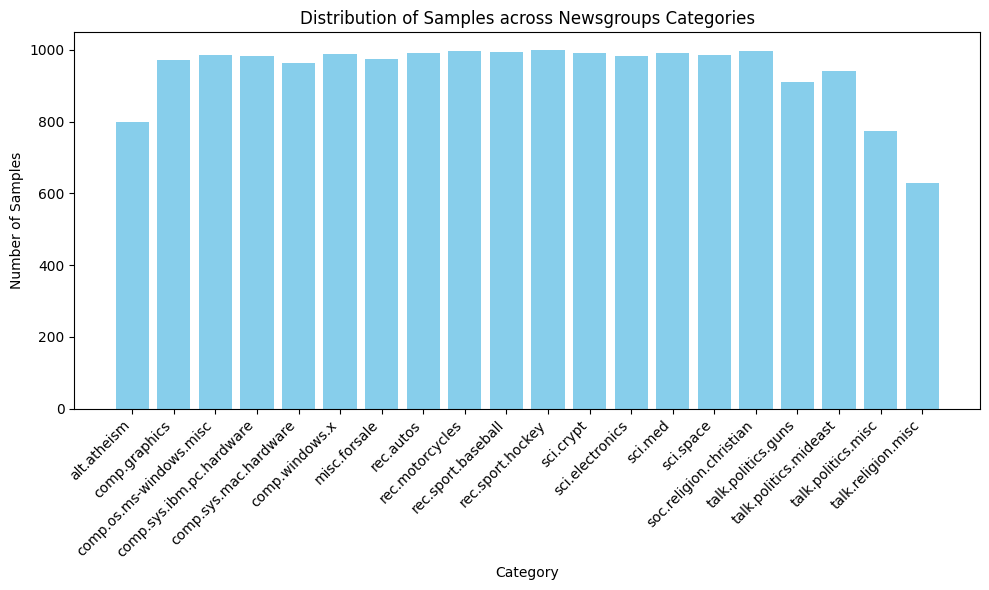

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(newsgroups.target_names, counts, color='skyblue')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples across Newsgroups Categories')
plt.xticks(rotation=45, ha='right')  # Rotate category names for better visibility

# Display the plot
plt.tight_layout()
plt.show()


### Histogram of tokens per article

In [23]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
dataset_encoding = tokenizer(texts, truncation=False, padding=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (1574 > 512). Running this sequence through the model will result in indexing errors


In [24]:
seq_len = [sum(input_id) for input_id in dataset_encoding['attention_mask']]

### avearage number of tokens per label

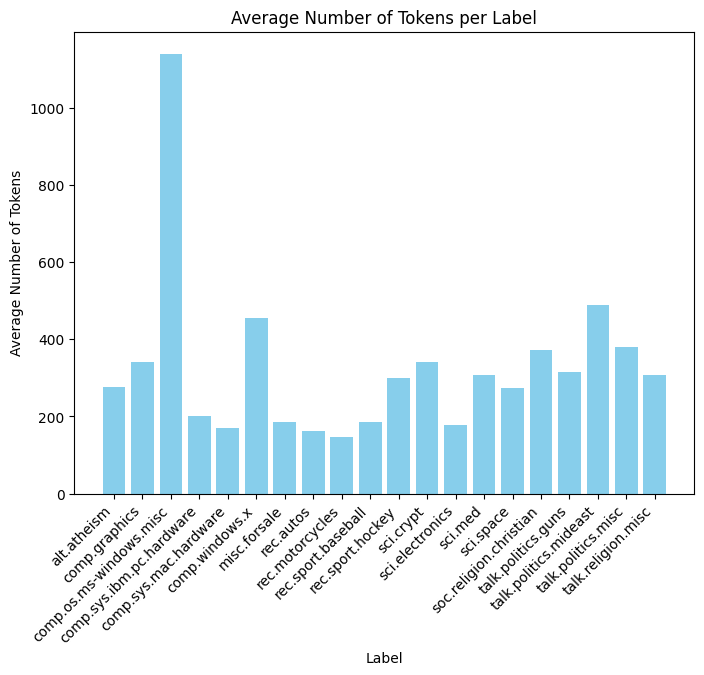

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming seq_len and labels are given as lists or numpy arrays
#
# Convert to numpy arrays for easier manipulation (optional, but useful)
seq_len = np.array(seq_len)
labels = np.array(labels)

# Get unique labels
unique_labels = np.unique(labels)

# Initialize a list to hold average token count for each label
avg_tokens_per_label = []

# Compute average number of tokens for each label
for label in unique_labels:
    avg_tokens = np.mean(seq_len[labels == label])
    avg_tokens_per_label.append(avg_tokens)

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(newsgroups.target_names, avg_tokens_per_label, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Average Number of Tokens')
plt.title('Average Number of Tokens per Label')
plt.xticks(rotation=45, ha='right')
plt.xticks(unique_labels)  # Ensure labels are shown on the x-axis
plt.show()


In [14]:
print(texts[11])
print("\nOriginal class is " ,newsgroups.target_names[labels[11]])

>say they have a "history of untrustworthy behavoir[sic]"?

Original class is  sci.crypt


In [11]:
cnt = 0
for i,len in enumerate(seq_len):
    if(len<30):
        print(i)
        cnt+=1
print(cnt)

11
47
53
68
71
73
80
91
99
100
104
127
135
137
148
150
161
168
174
180
185
191
192
199
200
204
205
206
219
227
230
246
254
263
268
271
272
282
285
297
318
325
330
335
338
341
349
389
428
430
461
482
489
527
532
535
538
539
547
548
559
566
567
582
591
597
646
653
662
663
680
691
702
712
725
729
735
737
760
766
781
791
811
812
832
843
846
847
864
875
881
884
885
895
902
922
929
945
948
953
961
984
996
998
1000
1001
1018
1027
1045
1056
1073
1079
1084
1085
1088
1097
1107
1110
1112
1127
1141
1142
1159
1200
1231
1251
1253
1261
1271
1291
1296
1305
1316
1318
1320
1326
1330
1353
1370
1400
1414
1435
1448
1454
1458
1471
1520
1529
1547
1550
1557
1566
1579
1600
1611
1612
1636
1642
1649
1650
1653
1659
1702
1713
1721
1724
1733
1743
1746
1747
1755
1772
1774
1808
1810
1814
1834
1842
1859
1864
1867
1881
1888
1907
1919
1923
1938
1963
1977
1988
1997
1998
2005
2012
2013
2016
2020
2024
2025
2030
2038
2043
2046
2055
2076
2089
2102
2103
2105
2107
2111
2115
2140
2144
2151
2156
2160
2162
2163
2165
2172
2176
217

[161, 74, 452, 183, 161, 87, 42, 221, 85, 112, 49, 22, 1574, 75, 98, 180, 157, 113, 972, 371, 465, 98, 192, 136, 297, 53, 159, 51, 321, 393, 188, 57, 39, 56, 50, 90, 61, 40, 364, 137, 143, 68, 258, 39, 3336, 210, 115, 25, 318, 52, 118, 122, 134, 16, 267, 90, 391, 221, 88, 433, 188, 456, 62, 1287, 257, 80, 60, 84, 26, 41, 293, 29, 184, 20, 221, 451, 82, 134, 126, 139, 18, 89, 120, 88, 61, 108, 214, 937, 31, 352, 40, 2, 929, 109, 416, 347, 170, 163, 83, 8]


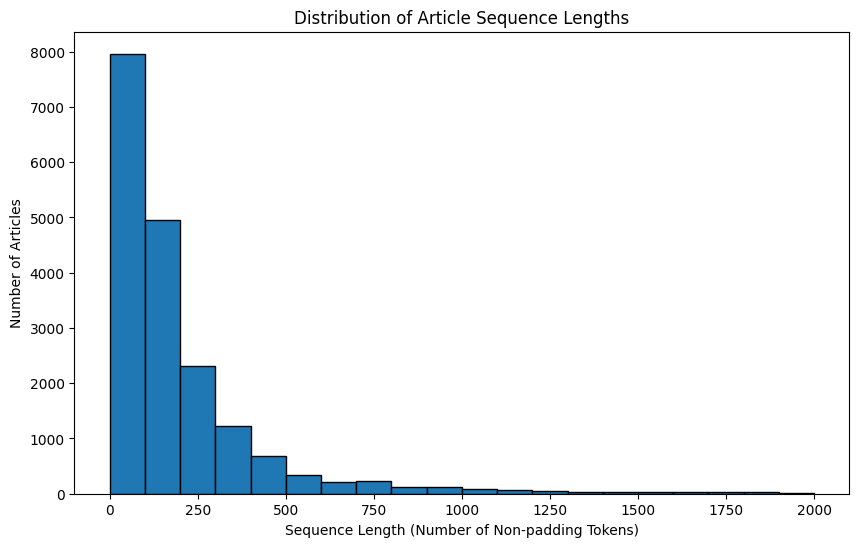

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Print first 100 sequence lengths to inspect
print(seq_len[:100])
# Find the min and max sequence length to create bins
min_seq_len = min(seq_len)
max_seq_len = 2000

bin_size = 100
bins = list(range(min_seq_len // bin_size * bin_size, max_seq_len + bin_size, bin_size))

# Plot histogram with defined bins
plt.figure(figsize=(10, 6))
plt.hist(seq_len, bins=bins, edgecolor='black')

# Set labels and title
plt.xlabel('Sequence Length (Number of Non-padding Tokens)')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Sequence Lengths')

# Show the plot
plt.show()


## Summazizer

In [17]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
from sklearn.model_selection import train_test_split
import time

# Load BART for summarization
model_name = "facebook/bart-large-cnn"
bart_tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def summarize_text(text, max_tokens=500):
    if not text.strip():  # Handle empty or whitespace-only text
        return ""

    # Tokenize and encode the input text
    inputs = bart_tokenizer(text, return_tensors="pt", truncation=True, max_length=1024, padding=True)
    
    # Move input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate summary
    summary_ids = model.generate(
        inputs["input_ids"], 
        max_length=max_tokens, 
        min_length=300, 
        length_penalty=0.8, 
        num_beams=4, 
        early_stopping=True
    )
    
    # Decode the summary and return it
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


def process_text(doc):

    answer=""
    
    inputs = bert_tokenizer(doc, return_tensors="pt", truncation=False)
    attention_mask = inputs['attention_mask']
    size = torch.sum(attention_mask).item()
    if size > 450:
        summary = summarize_text(doc.strip(), max_tokens=500)
        answer = summary
    else:
        answer = doc
    
    return answer


start_time = time.time()
for i,doc in enumerate(texts):
    texts[i] = process_text(doc)
    #print(i)
    if i % 200 == 0 and i !=0:
        print(f'Reached {i}/{len(texts)}')
        print(f"time done = {time.time()-start_time}")
        print(f"estimated time = {(time.time()-start_time)*18000/(i*60)}")
    

X_train, X_temp, y_train, Y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


Reached 200/18846
time done = 0.42488765716552734
estimated time = 0.6373518705368042
Reached 400/18846
time done = 5.931117296218872
estimated time = 4.448347270488739
Reached 600/18846
time done = 125.82826161384583
estimated time = 62.91413700580597
Reached 800/18846
time done = 272.0037181377411
estimated time = 102.00140109658241
Reached 1000/18846
time done = 363.39116644859314
estimated time = 109.01735372543335
Reached 1200/18846
time done = 473.72434258461
estimated time = 118.43108904361725
Reached 1400/18846
time done = 598.2545962333679
estimated time = 128.19741853645868
Reached 1600/18846
time done = 687.0714447498322
estimated time = 128.82589825987816
Reached 1800/18846
time done = 787.9643578529358
estimated time = 131.32739508152008
Reached 2000/18846
time done = 909.3259017467499
estimated time = 136.3988885164261
Reached 2200/18846
time done = 1016.8503682613373
estimated time = 138.66141664981842
Reached 2400/18846
time done = 1159.8323192596436
estimated time = 14

# Model definition

In [5]:
# Define your custom model class
class CustomBERT(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERT, self).__init__()
        
        # Load the pretrained BERT model
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        
        # Define a custom classification head
        self.dropout = nn.Dropout(0.3)  # Dropout layer to prevent overfitting
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 512)  # Fully connected layer (hidden_size is typically 768 for BERT-base)
        self.relu = nn.ReLU()           # Activation function (ReLU)
        # self.fc2 = nn.Linear(512, 256)  # Uncomment this
        # self.fc3 = nn.Linear(256, num_labels)  # Uncomment this
        self.fc2 = nn.Linear(512, num_labels)  # Samarth: comment this
            
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        
        # Take the [CLS] token representation (pooled output)
        cls_output = bert_output.pooler_output

        # #max pooling
        # input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        # token_embeddings = token_embeddings * input_mask_expanded  # Zero out padding embeddings
        # max_output, _ = torch.max(token_embeddings, dim=1)  # Take max along sequence length
        # x = self.dropout(max_output)
        
        # Pass through custom layers
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.relu(x) Uncomment this
        # x = self.fc3(x) Uncomment this
        
        return x

# Tokenization

In [7]:
#load bert tokenizer
print(MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 2a)Chunking : Sliding window implementation

In [16]:
def sliding_window_tokenization(texts, labels, tokenizer, max_length=300):
    encodings = tokenizer(texts, truncation=False, padding=False, max_length=max_length)
    all_input_ids = []
    all_attention_masks = []
    all_labels = []  # List to store labels for each chunk
    cnt_larger = 0
    for i, enc in enumerate(encodings['input_ids']):
        # If the length exceeds max_length, split into chunks
        while len(enc) > max_length:
            print(f"here1 {cnt_larger}")
            cnt_larger+=1
            chunk = enc[:max_length]
            attention_mask = [1] * max_length
            all_input_ids.append(chunk)
            all_attention_masks.append(attention_mask)
            all_labels.append(labels[i])  # Append the label of the document to the chunk
            enc = enc[max_length:]
        
        # Add remaining tokens as a chunk
        if len(enc) > 50:
            attention_mask = [1] * len(enc) + [0] * (max_length - len(enc))
            all_input_ids.append(enc + [0] * (max_length - len(enc)))
            all_attention_masks.append(attention_mask)
            all_labels.append(labels[i])  # Append the label of the document to the chunk
    
    return torch.tensor(all_input_ids), torch.tensor(all_attention_masks), torch.tensor(all_labels)

# Example usage:
train_input_ids, train_attention_mask, train_labels = sliding_window_tokenization(X_train, y_train, tokenizer)
test_input_ids, test_attention_mask, test_labels = sliding_window_tokenization(X_test, y_test, tokenizer)
val_input_ids, val_attention_mask, val_labels = sliding_window_tokenization(X_val, y_val, tokenizer)


here1 0
here1 1
here1 2
here1 3
here1 4
here1 5
here1 6
here1 7
here1 8
here1 9
here1 10
here1 11
here1 12
here1 13
here1 14
here1 15
here1 16
here1 17
here1 18
here1 19
here1 20
here1 21
here1 22
here1 23
here1 24
here1 25
here1 26
here1 27
here1 28
here1 29
here1 30
here1 31
here1 32
here1 33
here1 34
here1 35
here1 36
here1 37
here1 38
here1 39
here1 40
here1 41
here1 42
here1 43
here1 44
here1 45
here1 46
here1 47
here1 48
here1 49
here1 50
here1 51
here1 52
here1 53
here1 54
here1 55
here1 56
here1 57
here1 58
here1 59
here1 60
here1 61
here1 62
here1 63
here1 64
here1 65
here1 66
here1 67
here1 68
here1 69
here1 70
here1 71
here1 72
here1 73
here1 74
here1 75
here1 76
here1 77
here1 78
here1 79
here1 80
here1 81
here1 82
here1 83
here1 84
here1 85
here1 86
here1 87
here1 88
here1 89
here1 90
here1 91
here1 92
here1 93
here1 94
here1 95
here1 96
here1 97
here1 98
here1 99
here1 100
here1 101
here1 102
here1 103
here1 104
here1 105
here1 106
here1 107
here1 108
here1 109
here1 110


alt.atheism = 1011
comp.graphics = 1495
comp.os.ms-windows.misc = 4117
comp.sys.ibm.pc.hardware = 1043
comp.sys.mac.hardware = 924
comp.windows.x = 1871
misc.forsale = 981
rec.autos = 899
rec.motorcycles = 841
rec.sport.baseball = 952
rec.sport.hockey = 1358
sci.crypt = 1475
sci.electronics = 939
sci.med = 1365
sci.space = 1286
soc.religion.christian = 1603
talk.politics.guns = 1289
talk.politics.mideast = 1842
talk.politics.misc = 1263
talk.religion.misc = 858


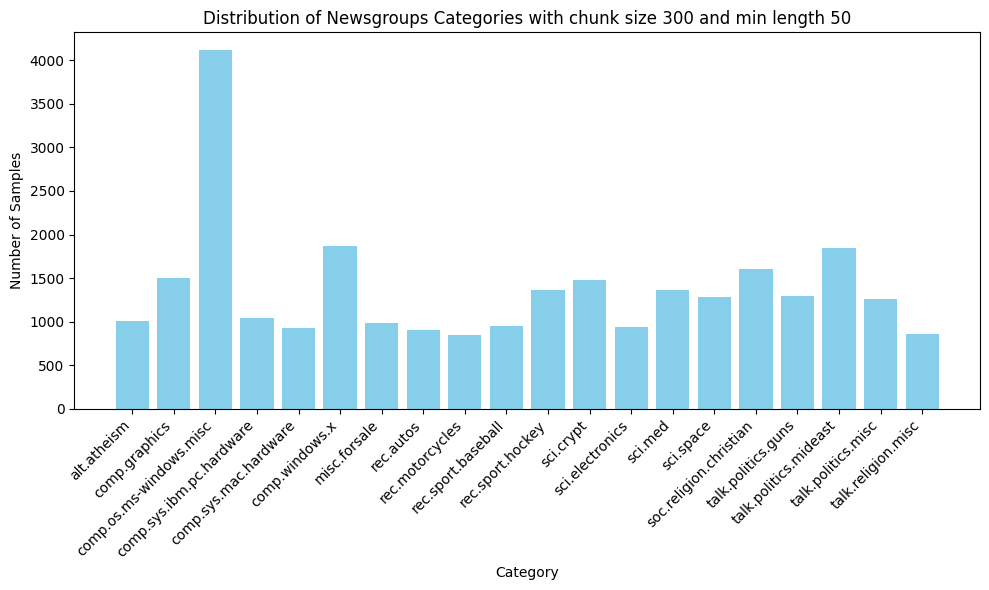

In [17]:
import matplotlib.pyplot as plt
import numpy as np

cnt_labels = [0]*20
for i in train_labels:
    cnt_labels[i]+=1
for i in test_labels:
    cnt_labels[i]+=1
for i in val_labels:
    cnt_labels[i]+=1 

for i,target in enumerate(newsgroups.target_names):
    print(f"{target} = {cnt_labels[i]}")

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(newsgroups.target_names, cnt_labels, color='skyblue')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.title('Distribution of Newsgroups Categories with chunk size 300 and min length 50')
plt.xticks(rotation=45, ha='right')  # Rotate category names for better visibility

# Display the plot
plt.tight_layout()
plt.show()

<Axes: >

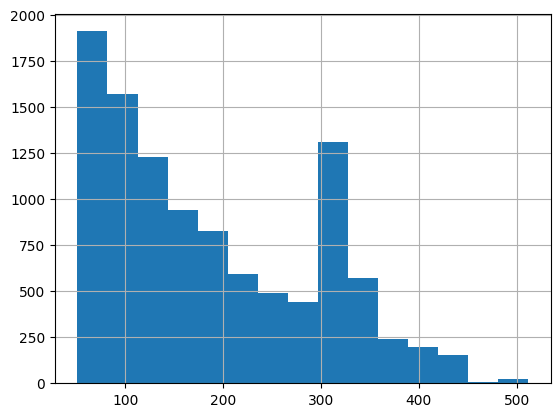

In [ ]:
# get length of all the messages in the train set

seq_len = [sum(input_id) for i,input_id in enumerate(train_attention_mask)]
int_values = [t.item() for t in seq_len]
pd.Series(int_values).hist(bins = 15)

## 2b)Code without Chunking

In [8]:
# Tokenize the texts
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)

train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_mask = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(y_train) 

test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask']) 
test_labels = torch.tensor(y_test) 

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask']) 
val_labels = torch.tensor(y_val) 


# Training Code

In [ ]:
# Convert to PyTorch tensors
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
import time 

device = torch.device("cuda:1" if torch.cuda.is_available() and torch.cuda.device_count() > 1 else "cpu")

print(device)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_dataset = TensorDataset(train_input_ids,
                               train_attention_mask,
                               train_labels)

val_dataset = TensorDataset(val_input_ids,
                              val_attention_mask,
                              val_labels)
test_dataset = TensorDataset(test_input_ids,
                              test_attention_mask,
                              test_labels)
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Vagarth - batch size 16 32 64
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

print("Dataset tokenized and created")
# Initialize the custom model
model = CustomBERT(pretrained_model_name=MODEL_NAME, num_labels=20)

# Move the model to the correct device

model = model.to(device)
print(model)
# Set optimizer
optimizer = AdamW(model.parameters(), lr=1e-5) # Vagarth - change to 5e-5
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)
best_valid_loss = 9999999999
# Train the model



model.train()
for epoch in range(6):
    total_loss = 0
    batch_no = 0
    start_time = time.time()
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
    for batch in train_dataloader:
        batch = [b.to(device) for b in batch]
        input_ids, attention_mask, labels = batch
        if(batch_no%50==0):
            print("batch no = ",batch_no)
        batch_no+=1
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    scheduler.step()
    
    current_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {current_loss}")
        
    # Validation check
    model.eval()  # Switch to evaluation mode for validation
    val_loss = 0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = [b.to(device) for b in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_preds / total_preds
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    print(f"time for epoch = {(time.time()-start_time)/60}")
    # Save the model if the validation loss improves
    if avg_val_loss < best_valid_loss:
        best_valid_loss = avg_val_loss
        torch.save(model.state_dict(), f'{SAVING_NAME}.pt')
        print(f"Saved model with validation loss: {best_valid_loss:.4f}")
    
    # Switch back to training mode
    model.train()

# Evaluate the model
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        batch = [b.to(device) for b in batch]
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cuda:1
Dataset tokenized and created


NameError: name 'CustomBERT' is not defined

In [43]:
print(len(X_train))
print(len(y_train))

13192
13192


In [ ]:
#uploading model
import kagglehub
print(f'saving name is {SAVING_NAME}')
kagglehub.login()

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = f'/kaggle/working/{SAVING_NAME}.pt'

kagglehub.model_upload(
  handle = 'saketnerurkar/bert_trained/pyTorch/default',
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = f"{SAVING_NAME}")

# F1 Score Calculator

In [15]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Assuming the following variables are already defined:
# test_seq, test_mask, and test_y are your test data tensors.

# Create a TensorDataset for the test data
#test_data = TensorDataset(test_seq, test_mask, test_y)

# Define a batch size for inference
batch_size = 32  # Adjust as needed based on available GPU memory

# Create a DataLoader for the test data
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Move model to the correct device
model = model.to(device)

# List to store predictions (if needed)
all_preds = []

# Start inference
with torch.no_grad():
    for batch in test_dataloader:
        # Unpack the batch
        test_seq_batch, test_mask_batch, _ = batch
        
        # Move the data to the correct device
        test_seq_batch = test_seq_batch.to(device)
        test_mask_batch = test_mask_batch.to(device)
        
        # Forward pass: Get predictions
        preds = model(test_seq_batch, test_mask_batch)
        
        # Detach predictions from the computation graph and move to CPU
        preds = preds.detach().cpu().numpy()
        
        # Append the predictions to the list
        all_preds.append(preds)
        
        # Optionally, clear GPU memory after each batch (especially useful for larger models)
        torch.cuda.empty_cache()

# Combine all the predictions into one array (if needed)
all_preds = np.concatenate(all_preds, axis=0)

# Optionally, you can now process `all_preds` or save them
print(f"Total predictions: {all_preds.shape}")


Total predictions: (2136, 20)


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Convert all_preds to discrete class predictions (if they're probabilities or logits)
# Assuming preds is the raw output (logits or probabilities) from the model

# For multiclass classification, use np.argmax to get the class with the highest probability/logit
#all_preds = np.argmax(all_preds, axis=1)

# Now compare the predictions with the ground truth labels
# Ensure test_y is in the same format (integer class labels)
test_y = true_labels # Move test_y to CPU if it's on the GPU (in case you're using CUDA)
# Print the classification report
print(classification_report(test_y, all_preds))
report = classification_report(test_y, all_preds, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
report_df.to_csv(f'{SAVING_NAME}.csv', index=True)

print(f"Classification report saved to '{SAVING_NAME}.csv'")



              precision    recall  f1-score   support

           0       0.45      0.56      0.50        96
           1       0.67      0.61      0.64       102
           2       0.61      0.62      0.61       115
           3       0.54      0.64      0.59       117
           4       0.63      0.48      0.55       100
           5       0.74      0.88      0.80       121
           6       0.85      0.78      0.81       104
           7       0.84      0.85      0.84       117
           8       0.82      0.86      0.84       104
           9       0.93      0.93      0.93       106
          10       0.97      0.92      0.95       117
          11       0.90      0.80      0.84       119
          12       0.68      0.73      0.70       115
          13       0.91      0.88      0.90       109
          14       0.85      0.87      0.86       114
          15       0.66      0.87      0.75       109
          16       0.68      0.64      0.66       109
          17       0.89    

# Dechunking

In [ ]:
MODEL_FILE = '/kaggle/input/nlp_default/pytorch/default/1/DEFAULT_BATCH_16_LR_DECAY_1e5.pt'
# Load the saved model state
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERT(pretrained_model_name='bert-base-uncased', num_labels=20)
model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
model = model.to(device)
 
print("Model loaded successfully!")
 
 
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
import time 
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
 
train_dataset = TensorDataset(train_input_ids,
                               train_attention_mask,
                               train_labels)
 
val_dataset = TensorDataset(val_input_ids,
                              val_attention_mask,
                              val_labels)
test_dataset = TensorDataset(test_input_ids,
                              test_attention_mask,
                              test_labels)
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True) # Vagarth - batch size 16 32 64
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)
 
 
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
 
# Assuming the following variables are already defined:
# test_seq, test_mask, and test_y are your test data tensors.
 
# Define a batch size for inference
batch_size = 32  # Adjust as needed based on available GPU memory
 
# Create a DataLoader for the test data
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
 
# Move model to the correct device
model = model.to(device)
 
# List to store predictions (if needed)
all_preds = []
true_labels = []
 
# Start inference
with torch.no_grad():
    for batch in test_dataloader:
        # Unpack the batch
        test_seq_batch, test_mask_batch, labels = batch
        
        # Move the data to the correct device
        test_seq_batch = test_seq_batch.to(device)
        test_mask_batch = test_mask_batch.to(device)
        
        # Forward pass: Get predictions (logits or probabilities)
        outputs = model(test_seq_batch, test_mask_batch)
        
        # For dechunking, we will aggregate the predictions (logits or probabilities)
        # Assuming the outputs are logits, we will first apply softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=-1)
 
        # We will store the logits/probs for each chunk for a document and then dechunk later
        all_probs = probs.cpu().numpy()
        all_labels = labels.cpu().numpy()
 
        # Now process chunk-wise predictions for dechunking
        for i, doc_label in enumerate(all_labels):
            # Get the chunked predictions for the document
            doc_probs = all_probs[i]
            
            # Simply sum all chunk probabilities/logits (no weighting)
            summed_probs = np.sum(doc_probs, axis=0)
 
            # Get the class with the maximum summed probability
            all_preds.append(np.argmax(summed_probs))  # Final prediction (max summed probability class)
 
        # Accumulate true labels for final evaluation
        true_labels.extend(all_labels)
 
# After processing all batches, calculate classification metrics
print(f"Total predictions: {len(all_preds)}")
print(classification_report(true_labels, all_preds))
 
# Generate the classification report and save it
report = classification_report(true_labels, all_preds, output_dict=True)
 
# Convert the dictionary to a pandas DataFrame
import pandas as pd
report_df = pd.DataFrame(report).transpose()
 
# Save the DataFrame to a CSV file
report_df.to_csv(f'{SAVING_NAME}.csv', index=True)
 
print(f"Classification report saved to '{SAVING_NAME}.csv'")

# Running Inference on News Articles

### Loading Model

In [15]:
MODEL_FILE = '/kaggle/input/default_bert_model/pytorch/default/1/DEFAULT_BATCH_16_LR_DECAY_1e5.pt'
# Load the saved model state
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERT(pretrained_model_name='bert-base-uncased', num_labels=20)
model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
model = model.to(device)
 
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'),)

/tmp/ipykernel_30/2308635059.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_FILE, map_location=device))


### Tokenize the input

In [19]:
article1 = """Inside were some shotguns and my dad’s .22-caliber bolt-action rifle. The scarred wooden gun had been given to him in the early 1950s, when he was around my age.

After some pleading and safety training with the rifle, my dad let me shoot it at a paper target outside. I don’t know when he said it, but I remember it distinctly: It was the first time he had fired a rifle since 1966, when he served in the Vietnam War.

So began my complicated relationship with firearms.

When I was a boy growing up in suburban Connecticut, target shooting at my grandfather’s farm in Maryland felt a little rebellious. At one point, I thought it would be cool to sew an N.R.A. patch onto my sweatshirt, but like most teenage boys I didn’t know how to sew, or care to learn.

Shooting was a hobby that made me feel different, as if I had a skill few of my classmates possessed. When I was 18, I even used money from a summer job to buy an M-1 Garand, the semiautomatic rifle used by American G.I.s in World War II."""

In [22]:
article2 = """NASA is keeping its foot on the gas for the space agency's Artemis program, announcing plans to assign demonstration missions for the two vehicles it has picked to land astronauts on the moon.

Both SpaceX and Blue Origin were awarded contracts for NASA's Human Landing System, and have been in the process of designing their respective vehicles for returning astronauts to the surface of the moon. Now, NASA has given both companies a heads-up to expect to put those designs to the test in some upcoming qualification missions that will task them with sending large cargo to the moon.

The mission assignments follow a 2023 request from NASA, which also directed SpaceX and Blue Origin to build cargo variants of their lunar landers, the space agency indicated in a statement. Having two different lunar landing systems to choose from will give NASA flexibility for both crew and cargo missions, while also "ensuring a regular cadence of moon landings for continued discovery and scientific opportunity,” said Stephen D. Creech, NASA's assistant deputy associate administrator for technical at the agency's Moon to Mars Program Office.

"""

In [25]:
article3 = """EAS was invented in 1966 by an American inventor Arthur Minasy. Since then, the EAS technology has evolved, and different types of it have come and gone.  The two most common ones that are still widely in use today are AM (acousto-magnetic) and RF (radio frequency) systems.

A deep technical discussion about the differences between the two systems is beyond the scope of this article, so we will just go over the basic differences that matter most to retailers. The AM systems work at the frequency of 58 kHz (kilohertz), while the RF systems work at the frequency of 8.2 MHz (megahertz). Visually they are very similar, and to an untrained eye they look the same."""

In [26]:
import torch
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Input text
input_text = article3

# Tokenize the input text
inputs = tokenizer(input_text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move inputs to the same device as the model (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {key: value.to(device) for key, value in inputs.items() if key != 'token_type_ids'}


In [27]:

# Put the model in evaluation mode
model.eval()

# Perform inference (disable gradient calculations)
with torch.no_grad():
    outputs = model(**inputs)

# If the model is for classification, get the logits (the raw prediction scores)
logits = outputs

# For classification, you might want to get the predicted class
predicted_class = torch.argmax(logits, dim=1)

# Print the output
print(f"Logits: {logits}")
print(f"Predicted Class: {predicted_class.item()} which is : {newsgroups.target_names[predicted_class.item()]}")

Logits: tensor([[-2.1191e+00,  1.2642e+00, -1.1617e+00,  7.6828e-01,  2.4590e+00,
         -1.7616e+00,  1.4278e+00,  7.9009e-01,  7.8136e-01, -2.2621e+00,
         -1.9226e+00, -1.1661e+00,  5.9214e+00, -2.0054e-01, -3.3745e-03,
         -3.0795e+00, -2.7574e+00, -3.9670e+00, -3.5581e+00, -1.8621e+00]],
       device='cuda:0')
Predicted Class: 12 which is : sci.electronics
